## Blosum strategies
* This file compares using the original blosum rows as features vs. doing eigenvalue decomposition and then constructing features

In [1]:
import os, sys
import numpy as np
import json
import random
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import linalg as LA

## Preliminary

In [2]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids

NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*12 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
uniform_pvals = [0.05]*20

encoding_style = 'regular'
alpha=10
beta=0.1

In [3]:
# New distribution (not NNK exactly)
aa_list_2 = ["A", "C", "D", "E", "F", "G", "H",  "I",  "K",  "L",  "M",  "N", "P", "Q", "R", "S", "T", "V",  "W", "Y"]
pvals_2 = [0.07668660126327106, 0.035596693992742914, 0.02474465797607849, 0.04041795457599785, 0.02319916677865878, 0.1149711060341352, 0.02187206020696143, 0.021972853111140975, 0.030170675984410696, 0.0904280338664158, 0.030069883080231154, 0.017672355866147026, 0.03937642789947588, 0.03156497782556108, 0.1183812659588765, 0.07880325225104153, 0.043290552345114905, 0.08557317564843435, 0.053369842763069476, 0.02183846257223492]

In [4]:
# Original BLOSUM62 matrix
original_blosum62 = {}
with open('blosum62.txt', 'r') as f:
    for line in f:
        split_line = line.strip().split()
        aa = split_line[0]
        encoding = [int(x) for x in split_line[1:-3]]
        original_blosum62[aa] = encoding

In [5]:
blosum_matrix = np.zeros((20, 20))
for i, aa in enumerate(original_blosum62.keys()):
    sims = original_blosum62[aa]
    for j, s in enumerate(sims):
        blosum_matrix[i][j] = s   
u, V = LA.eig(blosum_matrix)
clipped_u = u
clipped_u[clipped_u < 0] = 0
lamb = np.diag(clipped_u)
T = V
clip_blosum62 = {}
for i, aa in enumerate(original_blosum62.keys()):
    clip_blosum62[aa] = np.dot(np.sqrt(lamb), V[i])

In [6]:
# Biological features
# kd hydrophobicity scale
hydrophobicity = {'G': -0.4, 'A': 1.8, 'L':3.8, 'M': 1.9, 'F':2.8, 'W':-0.9, 'K':-3.9, 'Q':-3.5, 'E':-3.5, 'S':-0.8, 'P':-1.6, 'V':4.2, 'I':4.5, 'C':2.5, 'Y':-1.3, 'H':-3.2, 'R':-4.5, 'N':-3.5, 'D':-3.5, 'T':-0.7}
# Ranked
polarity = {'A': 0.45, 'R': 0.75, 'N': 0.8, 'D': 0.95, 'C':0.35, 'Q': 0.85, 'E': 0.90, 'G': 0.55, 'H': 0.5, 'I': 0.05, 'L': 0.15, 'K': 1, 'M': 0.25, 'F': 0.1, 'P': 0.65, 'S': 0.7, 'T': 0.6, 'W': 0.3, 'Y': 0.4, 'V': 0.2}
# Van der waal's volume
volume = {'A': 67, 'R': 148, 'N': 96, 'D': 91, 'C':86, 'Q': 114, 'E': 109, 'G': 48, 'H': 118, 'I': 124, 'L': 124, 'K': 135, 'M': 124, 'F': 135, 'P': 90, 'S': 73, 'T': 93, 'W':163, 'Y':141, 'V': 105}

# TODO: branched, hydrophilic, hydrophobic, shape
charge = {'A': 2, 'R': 3, 'N': 2, 'D': 1, 'C': 2, 'E':1, 'Q':2, 'G':2, 'H': 3, 'I':2, 'L': 2, 'K': 3, 'M':2, 'F':2, 'P':2, 'S':2, 'T': 2, 'W':2, 'Y': 2, 'V':2 }

# Normalize all of the biological features:
# Charge
for k,v in charge.items():
    if v == 1:
        charge[k] = 0
    elif v == 2:
        charge[k] = 0.5
    else:
        charge[k] = 1.0

# Volume
for k,v in volume.items():
    volume[k] = v/163.0

#Polarity
min_v = -4.5
max_v = 4.5
for k,v in hydrophobicity.items():
    hydrophobicity[k] = (v - min_v)/(max_v - min_v)  

## Dataset

In [7]:
class BinaryDataset(Dataset):
    def __init__(self, filepath, distribution='NNK', negfilepath=None):
        def construct_binary_dataset(filepath, distribution='NNK', negfilepath=None):
            with open(filepath, 'r') as f:
                aptamer_data = json.load(f)
            pos_ds = []
            neg_ds = []
            gen_ds = []
            for aptamer in aptamer_data:
                peptides = aptamer_data[aptamer]
                for peptide in peptides:
                    pos_ds.append((aptamer, peptide, 1))
                    gen_ds.append((get_x(), get_y(distribution), 0))
            with open(negfilepath, 'r') as f:
                neg_data = json.load(f)
            for aptamer in neg_data:
                peptides = neg_data[aptamer]
                for peptide in peptides:
                    neg_ds.append((aptamer, peptide, 0))
            
            pos_ds = list(set(pos_ds)) #removed duplicates, random order
            neg_ds = list(set(neg_ds))
            gen_ds = list(set(gen_ds))
            return pos_ds, neg_ds, gen_ds

        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y(distribution):
            if distribution == 'NNK':
                y_idx = np.random.choice(20, 7, p=pvals)
                lst = aa_list
            elif distribution == 'uniform':
                y_idx = np.random.choice(20, 7, p=uniform_pvals)
                lst = aa_list
            elif distribution == 'new_nnk':
                y_idx = np.random.choice(20, 7, p=pvals_2)
                lst = aa_list_2
            y = "M"
            for i in y_idx:
                y += lst[i]
            return y

        self.pos_ds, self.neg_ds, self.gen_ds =construct_binary_dataset(filepath, distribution, negfilepath)

    def __len__(self):
        return min(len(self.pos_ds), len(self.neg_ds))

    def __getitem__(self,idx):
        return(self.pos_ds[idx], self.neg_ds[idx], self.gen_ds[idx])

In [8]:
class AUCDataset(Dataset):
    def __init__(self, filepath, negfilepath=None):
        def construct_dataset(filepath, negfilepath=None):
            with open(filepath, 'r') as f:
                aptamer_data = json.load(f)
            bio_ds = []
            neg_ds = []
            gen_ds = []
            for aptamer in aptamer_data:
                peptides = aptamer_data[aptamer]
                for peptide in peptides:
                    bio_ds.append((aptamer, peptide, 1))
                    gen_ds.append((get_x(), get_y('NNK'), 0))
            with open(negfilepath, 'r') as f:
                neg_data = json.load(f)
            for aptamer in neg_data:
                peptides = neg_data[aptamer]
                for peptide in peptides:
                    neg_ds.append((aptamer, peptide, 0))
            bio_ds = list(set(bio_ds)) #removed duplicates, random order
            gen_ds = list(set(gen_ds)) #removed duplicates, random order
            neg_ds = list(set(neg_ds))
 
            return bio_ds, neg_ds, gen_ds

        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x
        
         # Sample y from P_y (assume peptides follow NNK)
        def get_y(distribution='NNK'):
            if distribution == 'NNK':
                y_idx = np.random.choice(20, 7, p=pvals)
                lst = aa_list
            elif distribution == 'uniform':
                y_idx = np.random.choice(20, 7, p=uniform_pvals)
                lst = aa_list
            elif distribution == 'new_nnk':
                y_idx = np.random.choice(20, 7, p=pvals_2)
                lst = aa_list_2
            y = "M"
            for i in y_idx:
                y += lst[i]
            return y

        self.bio_ds, self.neg_ds, self.gen_ds = construct_dataset(filepath, negfilepath)

    def __len__(self):
        return min(len(self.bio_ds), len(self.neg_ds))

    def __getitem__(self,idx):
        return(self.bio_ds[idx], self.neg_ds[idx], self.gen_ds[idx])

In [9]:
binary_ds1=BinaryDataset(filepath="../data/pos_datasets/experimental_replicate_1.json", distribution='NNK', negfilepath='../data/neg_datasets/neg1_all_pairs_noArgi_noHis.json')
binary_ds2=BinaryDataset(filepath="../data/pos_datasets/experimental_replicate_2.json", distribution='NNK', negfilepath='../data/neg_datasets/neg2_all_pairs_noArgi_noHis.json')
n = len(binary_ds1.pos_ds)
m = int(0.8*n)
train_pos = binary_ds1.pos_ds[:m]
val_pos = binary_ds1.pos_ds[m:]
n = len(binary_ds1.neg_ds)
m = int(0.8*n)
train_neg = binary_ds1.neg_ds[:m]
val_neg = binary_ds1.neg_ds[m:]
n = len(binary_ds1.gen_ds)
m = int(0.8*n)
train_gen = binary_ds1.gen_ds[:m]
val_gen = binary_ds1.gen_ds[m:]

n = len(binary_ds2.pos_ds)
m = int(0.8*n)
train_pos2 = binary_ds2.pos_ds[:m]
val_pos2 = binary_ds2.pos_ds[m:]
n = len(binary_ds2.neg_ds)
m = int(0.8*n)
train_neg2 = binary_ds2.neg_ds[:m]
val_neg2 = binary_ds2.neg_ds[m:]
n = len(binary_ds2.gen_ds)
m = int(0.8*n)
train_gen2 = binary_ds2.gen_ds[:m]
val_gen2 = binary_ds2.gen_ds[m:]

train_pos += train_pos2
train_neg += train_neg2
train_gen += train_gen2
val_pos += val_pos2
val_neg += val_neg2
val_gen += val_gen2


In [10]:
auc_ds_1 = AUCDataset(filepath='../data/pos_datasets/experimental_replicate_3.json', negfilepath='../data/neg_datasets/neg3_all_pairs_noArgi_noHis.json')
auc_ds_2 = AUCDataset(filepath='../data/pos_datasets/experimental_replicate_4.json', negfilepath='../data/neg_datasets/neg4_all_pairs_noArgi_noHis.json')

## NN Model

In [11]:
# Expects peptides to be encoding according to BLOSUM62 matrix
# Expects aptamers to be one hot encoded
class BlosumNet(nn.Module):
    def __init__(self):
        super(BlosumNet, self).__init__()
        self.name = "BlosumNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(25, 50, 3, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(50, 25, 3, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(25, 10, 3) 
        
        # There are 20 channels
        self.cnn_pep_1 = nn.Conv1d(20, 40, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(40, 80, 3, padding=2)
        self.cnn_pep_3 = nn.Conv1d(80, 150, 3, padding=2)
        self.cnn_pep_4 = nn.Conv1d(150, 50, 3, padding=2)
        self.cnn_pep_5 = nn.Conv1d(50, 10, 3, padding=2)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(790, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [12]:
# Expects peptides to be encoding according to BLOSUM62 matrix
# Expects aptamers to be one hot encoded
class BlosumConvNet(nn.Module):
    def __init__(self):
        super(BlosumConvNet, self).__init__()
        self.name = "BlosumConvNet"
        self.single_alphabet = False
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(25, 100, 3, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(100, 200, 3, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(200, 300, 3) 
        
        # There are 20 channels
        self.cnn_pep_1 = nn.Conv1d(20, 40, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(40, 100, 3, padding=2)
        self.cnn_pep_3 = nn.Conv1d(100, 200, 3, padding=2)
        self.cnn_pep_4 = nn.Conv1d(200, 300, 3, padding=2)
        self.cnn_pep_5 = nn.Conv1d(300, 350, 3, padding=2)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(1400, 700 )
        self.fc2 = nn.Linear(700, 250)
        self.fc3 = nn.Linear(250, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [13]:
# Expects peptides to be encoding according to BLOSUM62 matrix
# Expects aptamers to be one hot encoded
class BlosumLinearNet(nn.Module):
    def __init__(self):
        super(BlosumLinearNet, self).__init__()
        self.name = "BlosumLinearNet"
        self.single_alphabet = False
        
        self.fc_apt_1 = nn.Linear(160, 200) 
        self.fc_apt_2 = nn.Linear(200, 250)
        self.fc_apt_3 = nn.Linear(250, 300)
        
        self.fc_pep_1 = nn.Linear(160, 200)
        self.fc_pep_2 = nn.Linear(200, 250)
        
        self.relu = nn.ReLU()
        
        self.fc_apt = nn.Sequential(self.fc_apt_1, self.fc_apt_2, self.fc_apt_3)
        self.fc_pep = nn.Sequential(self.fc_pep_1, self.fc_pep_2)
        
        self.fc1 = nn.Linear(550, 600)
        self.fc2 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        apt = self.fc_apt(apt)
        pep = self.fc_pep(pep)
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x

In [14]:
class LinearBaseline(nn.Module):
    def __init__(self):
        super(LinearBaseline, self).__init__()
        self.name = "LinearBaseline"
        self.single_alphabet = False
        
        self.fc_1 = nn.Linear(320, 1)
    
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc_1(x)
        x = torch.sigmoid(x)
        return x

In [15]:
class ConvBaseline(nn.Module):
    def __init__(self):
        super(ConvBaseline, self).__init__()
        self.name = "ConvBaseline"
        self.single_alphabet = True
        
        self.cnn_1 = nn.Conv1d(24, 1000, 3)
        self.fc_1 = nn.Linear(4500, 1)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(7) 
        
    
    def forward(self, pair):
        x = self.cnn_1(pair)
        x = self.relu(self.maxpool(x))
        x = x.view(-1, 1).T
        x = self.fc_1(x)
        x = torch.sigmoid(x)
        return x

In [16]:
class LinearTwoHead(nn.Module):
    def __init__(self):
        super(LinearTwoHead, self).__init__()
        self.name = "LinearTwoHead"
        self.single_alphabet=False
        
        self.fc_apt_1 = nn.Linear(160, 200) 
        self.fc_apt_2 = nn.Linear(200, 150)
        self.fc_apt_3 = nn.Linear(150, 100)
        
        self.fc_pep_1 = nn.Linear(160, 250)
        self.fc_pep_2 = nn.Linear(250, 100)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 

        
        
        self.fc_apt = nn.Sequential(self.fc_apt_1, self.relu, self.fc_apt_2, self.relu,  self.fc_apt_3)
        self.fc_pep = nn.Sequential(self.fc_pep_1, self.relu,  self.fc_pep_2)
        
        self.fc1 = nn.Linear(200, 100)
        self.fc2 = nn.Linear(100, 1)
        
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        apt = self.fc_apt(apt)
        pep = self.fc_pep(pep)
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x       

In [17]:
class ConvTwoHead(nn.Module):
    def __init__(self):
        super(ConvTwoHead, self).__init__()
        self.name = "ConvTwoHead"
        self.single_alphabet=False
        
        self.cnn_apt_1 = nn.Conv1d(4, 100, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(50, 150, 3, padding=2) 

        
        # There are 20 channels
        self.cnn_pep_1 = nn.Conv1d(20, 100, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(75, 150, 3, padding=2)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     )
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     )
        
        self.fc1 = nn.Linear(2600, 1300)
        self.fc2 = nn.Linear(1300, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [18]:
# class TwoHeadedConv(nn.Module):
#     def __init__(self):
#         super(TwoHeadedConv, self).__init__()
#         self.name = "TwoHeadedConv"
#         self.single_alphabet=False
        
#         self.cnn_apt_1 = nn.Conv1d(4, 1000, 3, padding=2)
#         self.cnn_apt_2 = nn.Conv1d(1000, 500, 3, padding=2)

        
#         # There are 20 channels
#         self.cnn_pep_1 = nn.Conv1d(20, 1000, 3, padding=2)
#         self.cnn_pep_2 = nn.Conv1d(1000, 500, 3, padding=2)
        
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool1d(3) 
        
#         self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
#                                      self.cnn_apt_2, self.maxpool, self.relu,
#                                      )
#         self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
#                                      self.cnn_pep_2, self.maxpool, self.relu,
#                                      )
        
#         self.fc1 = nn.Linear(3000, 1500)
#         self.fc2 = nn.Linear(1500, 1)
    
#     def forward(self, apt, pep):
#         apt = self.cnn_apt(apt)
#         pep = self.cnn_pep(pep)
        
#         apt = apt.view(-1, 1).T
#         pep = pep.view(-1, 1).T
#         x = torch.cat((apt, pep), 1)
#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = torch.sigmoid(x)
#         return x
    
    
class TwoHeadedConv(nn.Module):
    def __init__(self):
        super(TwoHeadedConv, self).__init__()
        self.name = "TwoHeadedConv"
        self.single_alphabet=False
        self.cnn_apt_1 = nn.Conv1d(4, 1000, 3) 
        self.cnn_apt_2 = nn.Conv1d(1000, 2500, 1)
        
        self.cnn_pep_1 = nn.Conv1d(20, 1000, 3)
        self.cnn_pep_2 = nn.Conv1d(1000, 2500, 1)
       
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(5)         
        self.fc1 = nn.Linear(5000, 2500)
        self.fc2 = nn.Linear(2500, 1)
        
    def forward(self, apt, pep):

        
        apt = self.pool1(self.relu(self.cnn_apt_1(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_2(apt)))

        pep = self.relu(self.cnn_pep_1(pep))
        pep = self.pool1(self.relu(self.cnn_pep_2(pep)))
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x

In [19]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [20]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        apt = sequence[0]
        pep = sequence[1]
        one_hot = np.zeros((len(apt) + len(pep), 24))
        # Encode the aptamer first
        for i in range(len(apt)):
            char = apt[i]
            for _ in range(len(na_list)):
                idx = na_list.index(char)
                one_hot[i][idx] = 1
            
        # Encode the peptide second
        for i in range(len(pep)):
            char = pep[i]
            for _ in range(len(aa_list)):
                idx = aa_list.index(char) + len(na_list)
                one_hot[i+len(apt)][idx] = 1
        
        return one_hot       
    else:
        if seq_type == 'peptide':
            letters = aa_list
        else:
            letters = na_list
        one_hot = np.zeros((len(sequence), len(letters)))
        for i in range(len(sequence)):
            char = sequence[i]
            for _ in range(len(letters)):
                idx = letters.index(char)
                one_hot[i][idx] = 1
        return one_hot
    
## For aptamer sequence, translate
## For peptide sequence, translate and add additional biological properties
def extract_features(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        pass
    else:
        if seq_type == 'peptide':
            letters = aa_list
            encoding = np.zeros((4, len(sequence)))
            for i in range(len(sequence)):
                char = sequence[i]
                
                idx = letters.index(char)
                char_hydro = hydrophobicity[char]
                char_polar = polarity[char]
                char_vol = volume[char]
                char_charge = charge[char]
                
                # Put in the biological features of the amino acids
                encoding[0][i] = char_polar
                encoding[1][i] = char_vol
                encoding[2][i] = char_charge
                encoding[3][i] = char_hydro
        else:
            letters = na_list
            encoding = np.zeros(len(sequence))
            for i in range(len(sequence)):
                char = sequence[i]
                idx = letters.index(char)
                encoding[i] = idx
        return encoding 

def blosum62_encoding(sequence, seq_type='peptide', single_alphabet=False, style=encoding_style):
    if single_alphabet:
        apt = sequence[0]
        pep = sequence[1]
        encoding = np.zeros((len(apt) + len(pep), 24))
        # Encode the aptamer first
        for i in range(len(apt)):
            char = apt[i]
            for _ in range(len(na_list)):
                idx = na_list.index(char)
                encoding[i][idx] = 1
            
        # Encode the peptide second
        for i in range(len(pep)):
            char = pep[i]
            for j in range(len(original_blosum62[char])):
                encoding[i+len(apt)][j+4] = original_blosum62[char][j]
        
        return encoding      
    else:
        if seq_type == 'peptide':
            encoding = []
            for i in range(len(sequence)):
                if style == "clipped":
                    encoding.append(clip_blosum62[sequence[i]])
                else:
                    encoding.append(original_blosum62[sequence[i]])
            encoding = np.asarray(encoding)
        else:
            #Translation
            letters = na_list
            encoding = np.zeros(len(sequence))
            for i in range(len(sequence)):
                char = sequence[i]
                idx = letters.index(char)
                encoding[i] = idx
        return encoding 

## Takes a peptide and aptamer sequence and converts to directly translated sequence
def translate(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        apt = sequence[0]
        pep = sequence[1]
        
        encoding = np.zeros(len(apt) + len(pep))
        
        # Encode the aptamer first
        for i in range(len(apt)):
            char = apt[i]
            idx = na_list.index(char)
            encoding[i] = idx
            
        # Encode the peptide second
        for i in range(len(pep)):
            char = pep[i]
            idx = aa_list.index(char)
            encoding[i+len(apt)] = idx
        return encoding     
    else:
        if seq_type == 'peptide':
            letters = aa_list
        else:
            letters = na_list
        
        encoding = np.zeros(len(sequence))
        for i in range(len(sequence)):
            char = sequence[i]
            idx = letters.index(char)
            encoding[i] = idx
        return encoding

# Convert a pair to one-hot tensor
def convert(apt, pep, label, single_alphabet=False): 
    if single_alphabet:
        pair = one_hot([apt, pep], single_alphabet=True) #(2, 40)
        pair = torch.FloatTensor(np.reshape(pair, (-1, pair.shape[1], pair.shape[0]))).to(device)
        label = torch.FloatTensor([[label]]).to(device)
        return pair, label
    else:
        apt = one_hot(apt, seq_type='aptamer') 
        pep = one_hot(pep, seq_type='peptide') 
        apt = torch.FloatTensor(np.reshape(apt, (-1, apt.shape[1], apt.shape[0]))).to(device) #(1, 1, 40)
        pep = torch.FloatTensor(np.reshape(pep, (-1, pep.shape[1], pep.shape[0]))).to(device) #(1, 1, 8)
        
        label = torch.FloatTensor([[label]]).to(device)
        return apt, pep, label

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y, p, single_alphabet=False):
    if single_alphabet:
        p.requires_grad=True
        p = p.to(device)
        out = model(p)
        return out
    else:
        x.requires_grad=True
        y.requires_grad=True
        x = x.to(device)
        y = y.to(device)
        out = model(x, y)
        return out

## Plotting functions
def plot_loss(iters, train_losses, val_losses, model_name, model_id):
    plt.title("Loss Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/loss.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_accuracy(iters, train_acc, val_acc, model_name, model_id):
    plt.title("Training Accuracy Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/accuracy.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id):
    fig, ax = plt.subplots()
    plt.xlim(0, 1.1)
    
    sns.distplot(train_gen_scores , color="skyblue", label='Generated Train Samples', ax=ax)
    sns.distplot(val_gen_scores, color='dodgerblue', label='Generated Validation Samples')
    sns.distplot(train_scores , color="lightcoral", label='Dataset Train Samples', ax=ax)
    sns.distplot(val_scores, color='red', label='Dataset Validation Samples', ax=ax)
    
    ax.set_title("Categorizing the output scores of the model")
    ax.figure.set_size_inches(7, 4)
    ax.legend()
    plt.savefig('plots/binary/%s/%s/histogram.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_test(test_score, iters, epoch, gamma, model_name, model_id):
    test_idx = np.argsort(test_score)
    test_id = test_idx >= 10000
    test = np.sort(test_score)
    test_c = ""
    for m in test_id:
        if m:
            test_c += "y"
        else:
            test_c += "g"
    n = test_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, test, c=test_c, label='Test CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" %iters)
    plt.title('Test CDF at epoch %d' %epoch + ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/binary/%s/%s/test_cdf.png' %(model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_train(train_score, iters, epoch, gamma, model_name, model_id):
    train_idx = np.argsort(train_score)
    train_id = train_idx >= 10000
    train = np.sort(train_score)
    train_c = "" #colors
    for l in train_id:
        if l:
            train_c += "r"
        else:
            train_c += "b"
    n = train_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, train, c=train_c, label='Train CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" % iters)
    plt.title('Train CDF at epoch %d' %epoch+ ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/binary/%s/%s/train_cdf.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def auc_cdf(train, new, model_name, model_id, val=False): 
    #train is the sorted list of outputs from the model with training pairs as inputs
    #new is the list of outputs from the model with generated pairs as inputs
    a = train + new
    n = len(a)
    m = len(train)
    train = np.asarray(train)
    new = np.asarray(new)
    y = np.arange(0, m+2)/m
    gamma = [0]
    for x in train:
        gamma.append(sum(a<=x)/n)
    gamma.append(1)
    plt.plot(gamma, y)
    if val:
        plt.title("Validation CDF")
    else:
        plt.title("Train CDF")
    plt.xlim([0,1])
    if val:
        plt.savefig('plots/binary/%s/%s/val_cdf.png' % (model_name, model_id), bbox_inches='tight')
    else:
        plt.savefig('plots/binary/%s/%s/train_cdf.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()
    plt.close()
    return np.trapz(y, gamma)

In [21]:
# Test the translate method with single alphabet
pair, label = convert("GGGG", "LL", label=1.0, single_alphabet=True)
pair.shape

torch.Size([1, 24, 6])

## Binary Classification

In [22]:
if device == torch.cuda:
    torch.cuda.empty_cache()

In [23]:
def classifier(model, 
               pos, 
               neg,
               gen,
               val_pos,
               val_neg,
               val_gen,
               lr,
               model_id,
               num_epochs=50,
               batch_size=16,
               single_alphabet=False,
               run_from_checkpoint=None, 
               save_checkpoints=None,
               cdf=False):
    
    if run_from_checkpoint is not None:
        checkpointed_model = run_from_checkpoint
        checkpoint = torch.load(checkpointed_model)
        optimizer = SGD(model.parameters(), lr=lr)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        init_epoch = checkpoint['epoch'] +1
        print("Reloading model: ", model.name, " at epoch: ", init_epoch)
    else:
        model.apply(weights_init)
        optimizer = SGD(model.parameters(), lr=lr)
        init_epoch = 0
    
    train_losses, val_losses, train_losses_avg, val_losses_avg, train_acc, val_acc = [], [], [], [], [], []
    
    iters, train_correct, val_correct = 0, 0, 0
    criterion = nn.BCELoss()
    scheduler = StepLR(optimizer, step_size=10, gamma=0.9) #Decays lr by gamma factor every step_size epochs. 
    
    # Keep track of the scores across four classes
    train_scores, train_gen_scores, val_scores, val_gen_scores = [], [], [], []
    
    # TP, TN, FP, FN
    train_stats = [0, 0, 0, 0]
    val_stats = [0, 0, 0, 0]
    
    # Number of times that val_score < train_score
    auc_tracker = 0
    auc_count = 0
    
    alpha = 10
    beta = 0.1
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        full_epoch = epoch + init_epoch
        print("Starting epoch: %d" % full_epoch, " with learning rate: ", scheduler.get_lr())
        for i in tqdm.tqdm(range(100000)):
            num = random.uniform(0, 1)
            if num < 0.33:
                lam = 1
                apt,pep,label = random.choice(pos)
            elif num >= 0.33 and num < 0.67:
                lam = alpha
                apt,pep,label = random.choice(neg)
            elif num >= 0.67 and num <= 1:
                lam = beta
                apt,pep,label = random.choice(gen)
            
            # Pick 
            model_name = model.name
            model.train()
            if single_alphabet:
                p, l = convert(apt, pep, label, single_alphabet=True)
                train_score = update(None, None, p, single_alphabet=True)
            else:
                a, p, l = convert(apt, pep, label, single_alphabet=False)
                train_score = update(a, p, None, single_alphabet=False)

                
            iters += 1
            train_loss = criterion(train_score, l)
            total_train_loss += lam * train_loss

            
            if iters % batch_size == 0:
                ave_train_loss = total_train_loss/batch_size
                train_losses.append(ave_train_loss.item())
                optimizer.zero_grad()
                ave_train_loss.backward()
                optimizer.step()
                total_train_loss = 0

            if iters % 5000 == 0:
                train_acc.append(100*train_correct/iters)
                train_losses_avg.append(np.average(train_losses[-5000:]))

            with torch.no_grad():
                model.eval()
            
            num = random.uniform(0, 1)
            if num < 0.33:
                lam = 1
                apt,pep,label = random.choice(val_pos)
            elif num >= 0.33 and num < 0.67:
                lam = alpha
                apt,pep,label = random.choice(val_neg)
            elif num >= 0.67 and num <= 1:
                lam = beta
                apt,pep,label = random.choice(val_gen)
                
                
            if single_alphabet:
                p_val, l_val = convert(apt, pep, label, single_alphabet=True)
                val_score = model(p_val)
            else:
                a_val, p_val, l_val = convert(apt,pep,label)
                val_score = model(a_val, p_val)
            
            val_loss = criterion(val_score, l_val) 
            total_val_loss += lam * val_loss
            
            
            # Calculate AUC
            auc_count += 1
            idx = int(random.random()*len(val_pos))
            bio_sample = val_pos[idx]
            idx = int(random.random()*len(val_neg))
            gen_sample = val_neg[idx]
            if single_alphabet:
                p, l = convert(bio_sample[0], bio_sample[1], bio_sample[2], single_alphabet=True)
                bio_score = model(p)
                p, l = convert(gen_sample[0], gen_sample[1], gen_sample[2], single_alphabet=True)
                gen_score = model(p)
            else:
                a, p, l = convert(bio_sample[0], bio_sample[1], bio_sample[2])
                bio_score = model(a, p)
                a, p, l = convert(gen_sample[0], gen_sample[1], gen_sample[2])
                gen_score = model(a, p)
            if bio_score > gen_score:
                auc_tracker += 1

            if iters % batch_size == 0:
                ave_val_loss = total_val_loss/batch_size
                val_losses.append(ave_val_loss.item())
                total_val_loss = 0
            if iters % 5000 == 0:
                val_acc.append(100*val_correct/iters)
                val_losses_avg.append(np.average(val_losses[-5000:]))
                
            if iters % 50000 == 0:
                plot_loss(iters, train_losses_avg, val_losses_avg, model_name, model_id)
                plot_accuracy(iters, train_acc, val_acc, model_name, model_id)
                plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id)
                #val_auc = auc_cdf(sorted(val_scores[-1000:]), sorted(val_gen_scores[-10000:]), model_name, model_id, val=True)
                #train_auc = auc_cdf(sorted(train_scores[-1000:]), sorted(train_gen_scores[-10000:]), model_name, model_id)
                
                print("Training Accuracy at epoch %d: {}".format(train_acc[-1]) %full_epoch)
                print("Validation Accuracy epoch %d: {}".format(val_acc[-1]) %full_epoch)
                #print("Training CDF at epoch %d: {}".format(train_auc) % full_epoch)
                #print("Validation CDF epoch %d: {}".format(val_auc) % full_epoch)
                print("AUC epoch %d: {}".format(auc_tracker/float(auc_count)) % full_epoch)
                #print("Train: Sensitivity: " + str(train_stats[0]/(train_stats[0] + train_stats[3])) + " Specificity: " + str(train_stats[1]/(train_stats[2] + train_stats[1])))
                #print("Val: Sensitivity: " + str(val_stats[0]/(val_stats[0] + val_stats[3])) + " Specificity: " + str(val_stats[1]/(val_stats[2] + val_stats[1])))
#                 # TP, TN, FP, FN
#                 print("Train Precision: ", train_stats[0]/(train_stats[0] + train_stats[2]))
#                 print("Train Recall: ", train_stats[0]/(train_stats[0] + train_stats[3]))

        scheduler.step()
        if save_checkpoints is not None:
            print("Saving to: ", save_checkpoints)
            checkpoint_name = save_checkpoints
            torch.save({'epoch': full_epoch,
                        'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict()}, checkpoint_name)
        
        # Clear unused gpu memory at the end of the epoch
        if device == torch.cuda:
            torch.cuda.empty_cache()

  0%|          | 0/100000 [00:00<?, ?it/s]

Using encoding_style= regular
Starting epoch: 0  with learning rate:  [0.01]


 50%|████▉     | 49998/100000 [23:39<24:18, 34.29it/s]  

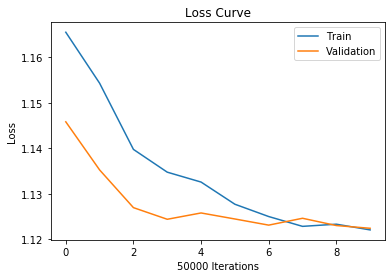

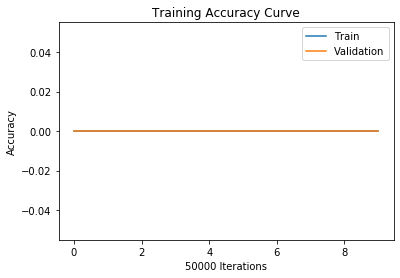

/home/yuhaowan/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


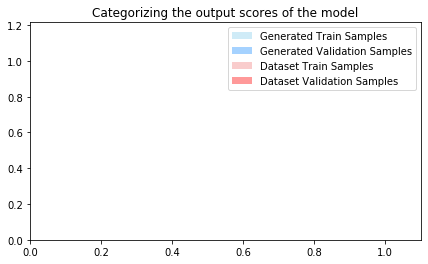

 50%|█████     | 50009/100000 [23:40<48:11, 17.29it/s]  

Training Accuracy at epoch 0: 0.0
Validation Accuracy epoch 0: 0.0
AUC epoch 0: 0.51374


 99%|█████████▉| 98942/100000 [46:53<00:23, 44.67it/s]

In [ ]:
model = TwoHeadedConv()
model_name = model.name
model_id = "09302020_100"
model.to(device)
checkpoint = None
save_path = 'model_checkpoints/binary/%s/%s.pth' % (model_name, model_id)
NUM_EPOCHS = 200
BATCH_SIZE = 64
cdf=False
if cdf:
   # For the CDF functions, we need to generate a dataset of new examples
    S_new = GeneratedDataset(10*m) 
gamma = 1e-2
#print("Using lambda val=", lambda_val)
print("Using encoding_style=", encoding_style)
classifier(model, train_pos, train_neg, train_gen, val_pos, val_neg, val_gen, gamma, model_id, NUM_EPOCHS, BATCH_SIZE, model.single_alphabet, checkpoint, save_path, cdf=cdf)

## Evaluate the model

In [ ]:
# Evaluate the decision threshold
def evaluate(model_name, model_id, dataset="ds2", use_gen=False):
    if model_name == "ConvBaseline":
        model = ConvBaseline()
    elif model_name == "LinearBaseline":
        model = LinearBaseline()
    elif model_name == "LinearTwoHead":
        model = LinearTwoHead()
    model.to(device)
    checkpointed_model = 'model_checkpoints/binary/%s/%s.pth' % (model.name, model_id)
    checkpoint = torch.load(checkpointed_model)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    if dataset=="3":
        ds = auc_ds_1
    elif dataset=='4':
        ds = auc_ds_2
    thresholds = [i for i in range(1, 100)]
    precisions = []
    recalls = []
    fprs = []
    tprs = []
    for i, t in enumerate(tqdm.tqdm(thresholds)):
        t = t*0.01
        tp, tn, fp, fn = 0, 0, 0, 0
        for i in range(100):
            idx = int(random.random()*len(ds))
            bio_sample, neg_sample, gen_sample = ds[idx]
            if model.single_alphabet:
                p, l = convert(bio_sample[0], bio_sample[1], bio_sample[2], single_alphabet=True)
                bio_score = model(p)
                if use_gen:
                    p, l = convert(gen_sample[0], gen_sample[1], gen_sample[2], single_alphabet=True)
                else:
                    p, l = convert(neg_sample[0], neg_sample[1], gen_sample[2], single_alphabet=True)
                gen_score = model(p) 
            else:
                a, p, l = convert(bio_sample[0], bio_sample[1], bio_sample[2])
                bio_score = model(a, p)
                if use_gen:
                    a, p, l = convert(gen_sample[0], gen_sample[1], gen_sample[2])
                else:
                    a, p, l = convert(neg_sample[0], neg_sample[1], gen_sample[2])
                gen_score = model(a, p)
            if bio_score >= t:
                tp += 1
            elif bio_score < t:
                fn += 1    
            if gen_score < t:
                tn += 1
            elif gen_score >= t:
                fp += 1


        try:
            precision = tp/float(tp + fp)
        except:
            precision = tp/1
        try:
            recall = tp/float(tp + fn)
        except:
            recall = tp/1

        precisions.append(precision)
        recalls.append(recall)

        # ROC stats
        fpr = fp/float(fp+tn)
        tpr = tp/float(tp+fn)
        fprs.append(fpr)
        tprs.append(tpr)
    
    roc_curve = zip(fprs, tprs)
    pr_curve = zip(recalls, precisions)
    
    roc_curve = sorted(roc_curve, key=lambda x: x[0])
    pr_curve = sorted(pr_curve, key=lambda x: x[0])
    
    roc_curve = list(zip(*roc_curve))
    pr_curve = list(zip(*pr_curve))
    return list(roc_curve[0]), list(roc_curve[1]), list(pr_curve[0]), list(pr_curve[1])

In [ ]:
## Generate ROC Curves for each method
methods = {'LinearBaseline': ['09272020_2', '09272020'],
           'ConvBaseline': ['09282020', '09282020_2'],
           'LinearTwoHead': ['09292020', '09292020']}

colors = ["lightcoral", "crimson", "lightgreen", "powderblue", "mediumpurple", "gold"]
use_gen = True
method = 'roc'
for ds in ["3", "4"]:
    plt.figure(figsize=(10,10))
    for i, network in enumerate(methods):
        blosum_method = methods[network][0]
        oh_method = methods[network][1]
        
        fprs, tprs, recalls, precisions = evaluate(network, blosum_method, ds, use_gen=use_gen)
        if method == 'prc':
            plt.plot(recalls, precisions, c=colors[2*i], label=str(network) + " blosum")
        else:
            plt.plot(fprs, tprs, c=colors[2*i], label=str(network) + " blosum ")
        
        fprs, tprs, recalls, precisions = evaluate(network, oh_method, ds, use_gen=use_gen)
        if method == 'prc':
            plt.plot(recalls, precisions, c=colors[2*i + 1], label=str(network) + " oh")
        else:
            plt.plot(fprs, tprs, c=colors[2*i + 1], label=str(network) + " oh ")
        
        
    
    plt.legend()
    if method == 'prc':
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        if use_gen:
            plt.title("Precision Recall Curve, Test Dataset: " + str(ds) + " using generated data")
        else:
            plt.title("Precision Recall Curve, Test Dataset: " + str(ds) + " using negative data")
    else:
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        
        if use_gen:
            plt.title("ROC Curve, Test Dataset: " + str(ds) + " using generated data")
        else:
            plt.title("ROC Curve, Test Dataset: " + str(ds) + " using negative data")

    plt.show()
    
    